In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv('Wimbledon_featured_matches.csv')

match_id = "2023-wimbledon-1701"
match_data = df[df['match_id'] == match_id].copy()
match_data.reset_index(inplace=True,drop=True)

window_size = 3

def calculate_momentum(df, index, window_size):
    
    start_index = max(index - window_size, 0)
    end_index = min(index + window_size + 1, len(df))
    time_window_df = df.iloc[start_index:end_index]

    p1_momentum = 0
    p2_momentum = 0

    p1_sets_won = time_window_df['p1_sets'].iloc[-1] - time_window_df['p1_sets'].iloc[0]
    p2_sets_won = time_window_df['p2_sets'].iloc[-1] - time_window_df['p2_sets'].iloc[0]

    p1_games_won = (time_window_df['p1_games'].iloc[-1] - time_window_df['p1_games'].iloc[0])*1.5
    p2_games_won = (time_window_df['p2_games'].iloc[-1] - time_window_df['p2_games'].iloc[0])*1.5

    serve_advantage_weight = 0.2
    
    p1_serve_advantage = (time_window_df[time_window_df['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight
    p2_serve_advantage = (time_window_df[time_window_df['server'] == 2]['point_victor'] == 2).sum() * serve_advantage_weight

    p1_points_advantage = (time_window_df['point_victor'].apply(lambda x: x == 1).sum() - time_window_df['point_victor'].apply(lambda x: x == 2).sum())
    p2_points_advantage = -p1_points_advantage

    p1_break_points_won = time_window_df['p1_break_pt_won'].sum()
    p2_break_points_won = time_window_df['p2_break_pt_won'].sum()

    p1_unforced_errors = -time_window_df['p1_unf_err'].sum()
    p2_unforced_errors = -time_window_df['p2_unf_err'].sum()

   # p1_winners = time_window_df['p1_winner'].sum()
   # p2_winners = time_window_df['p2_winner'].sum()

    p1_momentum = p1_points_advantage + p1_serve_advantage + p1_break_points_won + p1_unforced_errors + p1_sets_won + p1_games_won
    p2_momentum = p2_points_advantage + p2_serve_advantage + p2_break_points_won + p2_unforced_errors + p2_sets_won + p2_games_won

    return p1_momentum, p2_momentum

momentum_values = [calculate_momentum(match_data, index, window_size) for index in range(len(match_data))]

p1_momentum = [list(x)[0] for x in momentum_values]
p2_momentum = [list(x)[1] for x in momentum_values]

match_data['p1_momentum']=pd.DataFrame(p1_momentum)
match_data['p2_momentum']=pd.DataFrame(p2_momentum)


elapsed_seconds = match_data['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))

import math

def correct_or_not(df, index):

    p1_momentum = df.iloc[index]["p1_momentum"]
    p2_momentum = df.iloc[index]["p2_momentum"]

    if p1_momentum > p2_momentum and df.iloc[index]['point_victor'] == 1:
        return 1
    if p1_momentum < p2_momentum and df.iloc[index]['point_victor'] == 2:
        return 1
    else:
        return 0
    
prediction_correct = [correct_or_not(match_data, index) for index in range(len(match_data))]


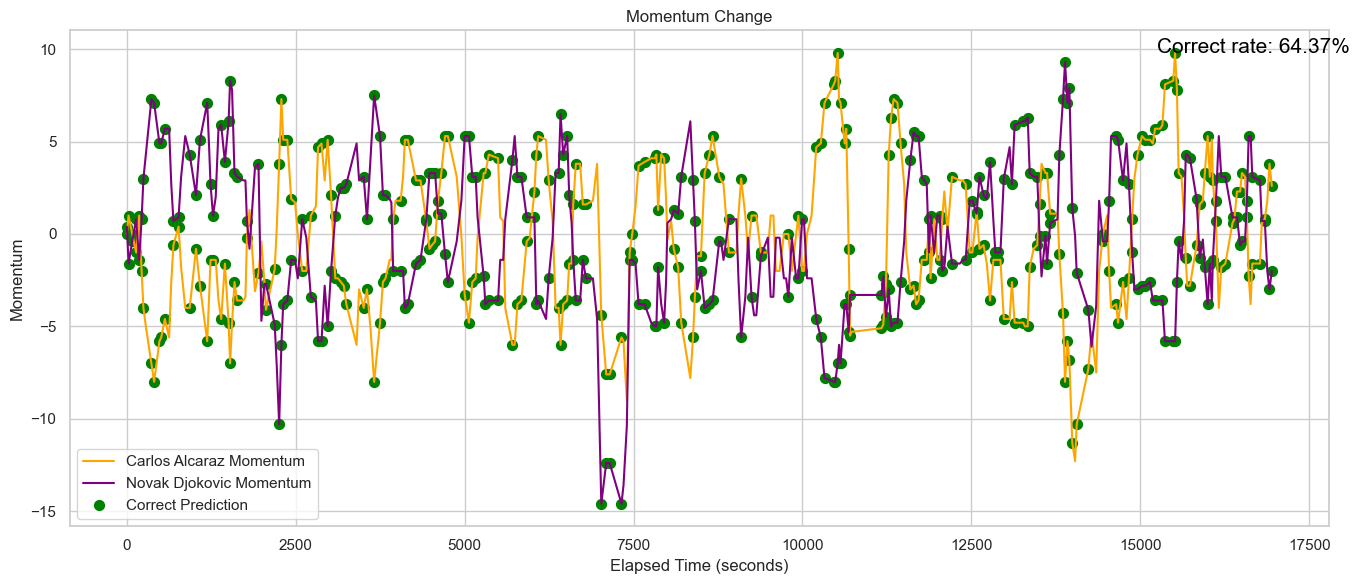

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'elapsed_seconds', 'match_data', 'p1_momentum', 'p2_momentum', and 'prediction_correct' are defined
# and contain the necessary data for plotting


correct_rate = np.array(prediction_correct).sum() / len(match_data)


# Set the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a figure and axis for the plot
plt.figure(figsize=(14, 6))

# Plot player 1's momentum change using Seaborn
sns.lineplot(x=elapsed_seconds, y=match_data['p1_momentum'], label=match_data['player1'].iloc[0] + " Momentum", color='orange')

# Plot player 2's momentum change using Seaborn
sns.lineplot(x=elapsed_seconds, y=match_data['p2_momentum'], label=match_data['player2'].iloc[0] + " Momentum", color='purple')

# Mark correct predictions
# Convert 'prediction_correct' to a numpy array for element-wise comparison
prediction_correct_array = np.array(prediction_correct)
correct_prediction_indices = np.where(prediction_correct_array == 1)[0]  # Get indices of correct predictions

# Overlay markers for correct predictions
# Assuming correct predictions apply to the overall momentum trend, not specific to any player
plt.scatter(x=np.array(elapsed_seconds)[correct_prediction_indices], y=np.array(match_data['p1_momentum'])[correct_prediction_indices], color='green', marker='o', label='Correct Prediction', s=50)  # Mark correct predictions for player 1
plt.scatter(x=np.array(elapsed_seconds)[correct_prediction_indices], y=np.array(match_data['p2_momentum'])[correct_prediction_indices], color='green', marker='o', s=50)  # Mark correct predictions for player 2

# Add legend
plt.legend()

# Set title and axis labels
plt.title('Momentum Change')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')
plt.text(x=max(elapsed_seconds) * 0.9, y=max(max(match_data['p1_momentum']), max(match_data['p2_momentum'])) * 1, s=f"Correct rate: {correct_rate:.2%}", fontsize=15, color='black')

# Improve plot readability
plt.tight_layout()

# Display the plot
plt.show()


Use logistic to obtain the parameters.

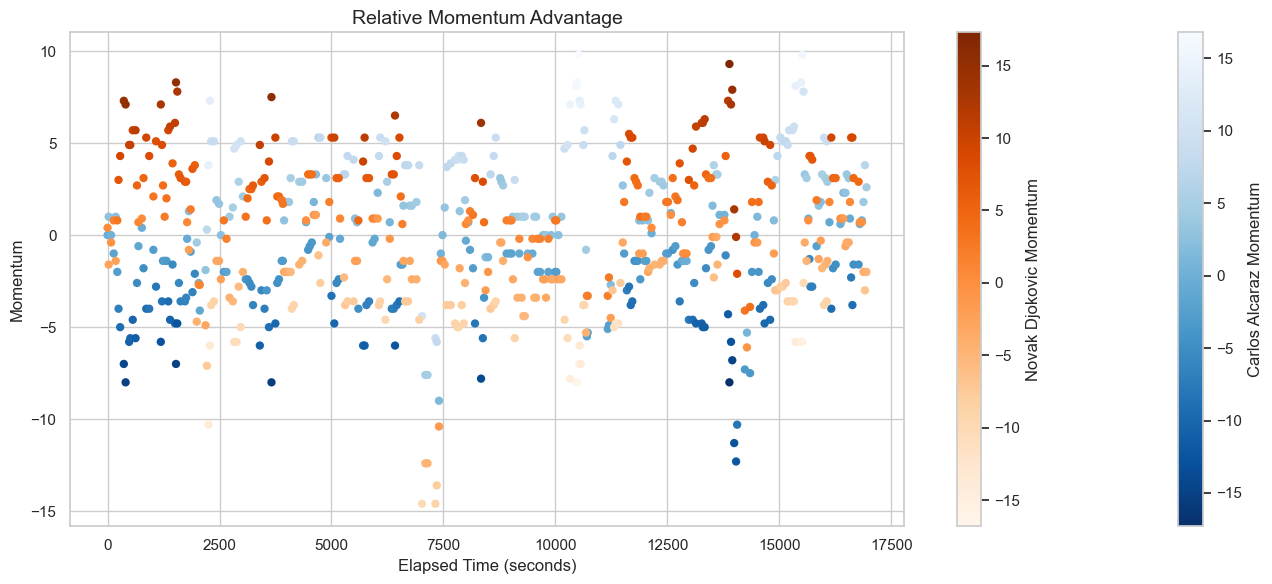

In [164]:
momentum_range = np.linspace(min(min(match_data['p1_momentum']), min(match_data['p2_momentum'])),
                             max(max(match_data['p1_momentum']), max(match_data['p2_momentum'])), num=100)
# 创建一个颜色映射对象
cmap = plt.get_cmap('viridis')

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
sc1 = plt.scatter(elapsed_seconds, match_data['p1_momentum'], c=match_data['p1_momentum'] - match_data['p2_momentum'], cmap='Blues_r', label=match_data['player1'].iloc[0] + " Momentum", edgecolor='none')
# 绘制球员2的势头变化
sc2 = plt.scatter(elapsed_seconds, match_data['p2_momentum'], c=match_data['p2_momentum'] - match_data['p1_momentum'], cmap='Oranges', label=match_data['player2'].iloc[0] + " Momentum", edgecolor='none')

# 添加颜色条
cbar1 = plt.colorbar(sc1, orientation='vertical')
cbar2 = plt.colorbar(sc2, orientation='vertical')
cbar1.set_label(match_data['player1'].iloc[0] + ' Momentum')
cbar2.set_label(match_data['player2'].iloc[0] + ' Momentum')

# 设置标题和坐标轴标签
plt.title('Relative Momentum Advantage',fontsize = 14)
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 显示图表
plt.grid(True)
plt.tight_layout()
plt.show()

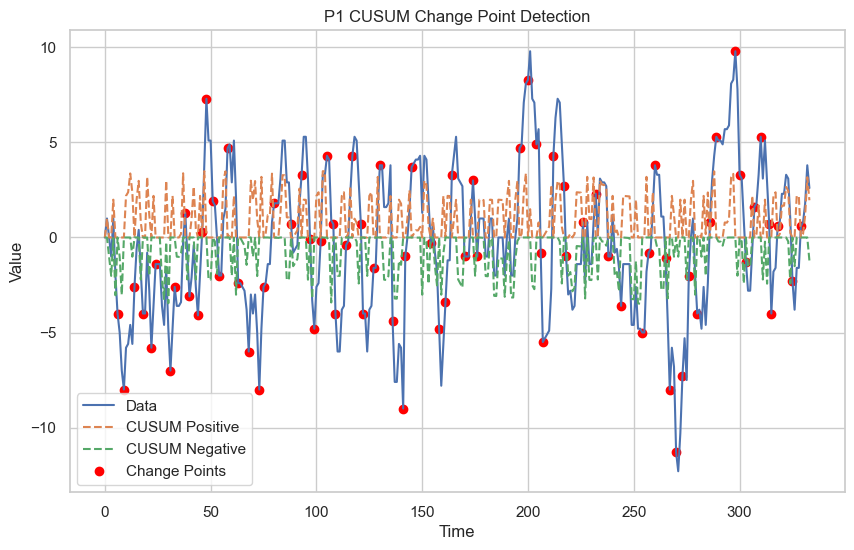

In [165]:
import numpy as np
import matplotlib.pyplot as plt

def cusum(data, threshold=1, drift=0):
    S_pos = np.zeros(len(data))
    S_neg = np.zeros(len(data))
    change_points = []

    for i in range(1, len(data)):
        S_pos[i] = max(0, S_pos[i-1] + data[i] - data[i-1] - drift)
        S_neg[i] = min(0, S_neg[i-1] + data[i] - data[i-1] - drift)
        if S_pos[i] > threshold or S_neg[i] < -threshold:
            change_points.append(i)
            S_pos[i] = 0
            S_neg[i] = 0

    return S_pos, S_neg, change_points

threshold = 3.5
drift = 0.01

S_pos, S_neg, p1_change_points = cusum(match_data['p1_momentum'], threshold, drift)

# 绘图展示
plt.figure(figsize=(10, 6))
plt.plot(match_data['p1_momentum'], label='Data')
plt.plot(S_pos, label='CUSUM Positive', linestyle='--')
plt.plot(S_neg, label='CUSUM Negative', linestyle='--')
plt.scatter(p1_change_points, match_data['p1_momentum'][p1_change_points], c='red', label='Change Points')
plt.legend()
plt.title('P1 CUSUM Change Point Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

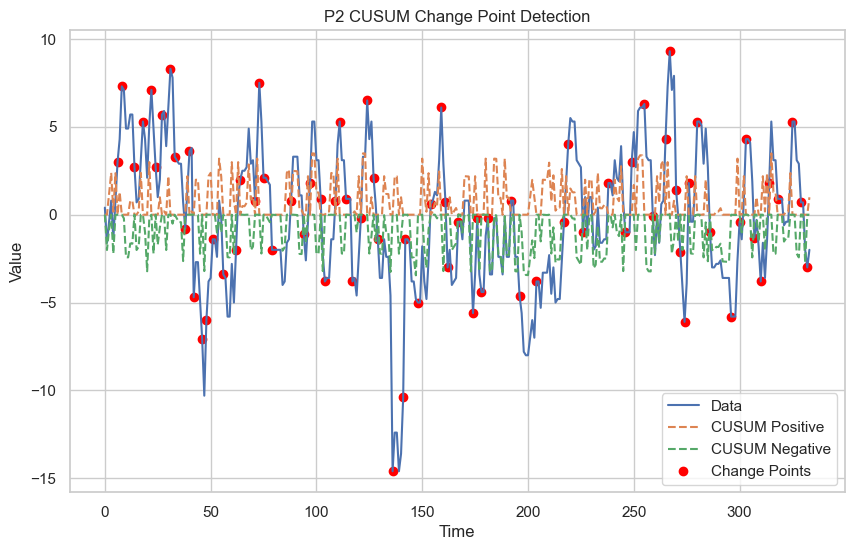

In [166]:
import numpy as np
import matplotlib.pyplot as plt

def cusum(data, threshold=1, drift=0):
    S_pos = np.zeros(len(data))
    S_neg = np.zeros(len(data))
    change_points = []

    for i in range(1, len(data)):
        S_pos[i] = max(0, S_pos[i-1] + data[i] - data[i-1] - drift)
        S_neg[i] = min(0, S_neg[i-1] + data[i] - data[i-1] - drift)
        if S_pos[i] > threshold or S_neg[i] < -threshold:
            change_points.append(i)
            S_pos[i] = 0
            S_neg[i] = 0

    return S_pos, S_neg, change_points

threshold = 3.5
drift = 0.01

S_pos, S_neg, p2_change_points = cusum(match_data['p2_momentum'], threshold, drift)

# 绘图展示
plt.figure(figsize=(10, 6))
plt.plot(match_data['p2_momentum'], label='Data')
plt.plot(S_pos, label='CUSUM Positive', linestyle='--')
plt.plot(S_neg, label='CUSUM Negative', linestyle='--')
plt.scatter(p2_change_points, match_data['p2_momentum'][p2_change_points], c='red', label='Change Points')
plt.legend()
plt.title('P2 CUSUM Change Point Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [167]:
tmp1 = [0 for i in range(len(match_data))]
tmp2 = [0 for i in range(len(match_data))]

for index in p1_change_points:
    tmp1[index-1] = 1
    

for index in p2_change_points:
    tmp2[index-1] = 1


match_data['p1_turning_points']=tmp1
match_data['p2_turning_points']=tmp2


In [168]:
from scipy.stats import norm

def runs_test(sequence):

    median_value = np.median(sequence)
    binary_sequence = [1 if x > median_value else 0 for x in sequence]

    runs = 1  
    for i in range(1, len(binary_sequence)):
        if binary_sequence[i] != binary_sequence[i-1]:
            runs += 1

    n1 = binary_sequence.count(1)
    n2 = binary_sequence.count(0)
    expected_runs = 2 * n1 * n2 / (n1 + n2) + 1
    variance = (expected_runs - 1) * (expected_runs - 2) / (n1 + n2 - 1)

    Z = (runs - expected_runs) / np.sqrt(variance)
    p_value = 2 * (1 - norm.cdf(abs(Z))) 
    
    return Z, p_value





print(runs_test(match_data['p1_momentum']))

print(runs_test(match_data['p2_momentum']))

print(runs_test(match_data['p1_turning_points']))

print(runs_test(match_data['p2_turning_points']))

(-11.727180639250733, 0.0)
(-12.710392382039306, 0.0)
(3.8540819109569635, 0.00011616470302389104)
(4.871995276974959, 1.1047681067744008e-06)
